In [1]:
#读取数据
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Train_data = pd.read_csv('./used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv('./used_car_testA_20200313.csv', sep=' ')

In [2]:
# reduce_mem_usage函数通过调整数据类型，帮助我们减少数据在内存中的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 69563904.00 MB
Memory usage after optimization is: 19092464.00 MB
Decreased by 72.6%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [8]:
# 线性回归& 五折交叉验证& 模拟真实业务情况
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_Y = train['price']

In [6]:
train_X.head()

,SaleID,bodyType,fuelType,gearbox,kilometer,name,notRepairedDamage,offerType,power,seller,...,brand_price_std_x,brand_price_average_x,brand_amount_y,brand_price_max_y,brand_price_median_y,brand_price_min_y,brand_price_sum_y,brand_price_std_y,brand_price_average_y,power_bin
0,0,1.0,0.0,0.0,12.5,736,0.0,0,60,0,...,3820.0,3140.0,9568.0,30333.0,1700.0,14.0,30040896.0,3820.0,3140.0,5.0
1,2,1.0,0.0,0.0,12.5,14874,0.0,0,163,0,...,4352.0,8704.0,1252.0,34990.0,7900.0,100.0,10910705.0,4352.0,8704.0,16.0
2,4,1.0,0.0,0.0,5.0,111080,0.0,0,68,0,...,2860.0,3034.0,4400.0,28600.0,2200.0,20.0,13355631.0,2860.0,3034.0,6.0
3,5,0.0,1.0,0.0,10.0,137642,0.0,0,109,0,...,7300.0,7484.0,13240.0,92900.0,5000.0,40.0,99085648.0,7300.0,7484.0,10.0
4,6,0.0,0.0,1.0,15.0,2402,0.0,0,150,0,...,7096.0,7792.0,15840.0,99999.0,5900.0,30.0,123470888.0,7096.0,7792.0,14.0


In [9]:
train_Y.head()

0    1850.0
1    6222.0
2    5200.0
3    8000.0
4    3500.0
Name: price, dtype: float64

In [10]:
# 简单建模
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)



In [11]:
#查看训练的线性回归模型的截距intercept与权重
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('offerType', 725572731083951.8),
 ('seller', 286504532816046.0),
 ('train', 246426788780860.03),
 ('brand_price_min_y', 28819772872386.367),
 ('brand_amount_y', 66206553083.32754),
 ('brand_price_average_x', 2348809316.7032933),
 ('brand_price_median_x', 1244614263.7145987),
 ('brand_price_std_x', 353709470.11090666),
 ('brand_price_max_y', 158677314.36086193),
 ('v_6', 3051961.389257771),
 ('v_8', 608177.8149851151),
 ('v_9', 138359.1624577285),
 ('brand_price_sum_x', 82520.16424175972),
 ('v_3', 14411.822032921738),
 ('v_13', 10926.247552965984),
 ('v_12', 10517.281926911332),
 ('v_10', 9236.941632868886),
 ('gearbox', 809.5582550829129),
 ('v_7', 515.3983563241555),
 ('fuelType', 302.6098459950813),
 ('bodyType', 191.29463018045948),
 ('power_bin', 102.38021303286189),
 ('city', 31.153582815108603),
 ('power', 12.272047083306743),
 ('SaleID', -1.4203711566946325e-05),
 ('name', -0.00016167511644539444),
 ('used_time', -0.02490814210632749),
 ('kilometer', -339.1405218139009),
 ('v

The predicted price is obvious different from true price


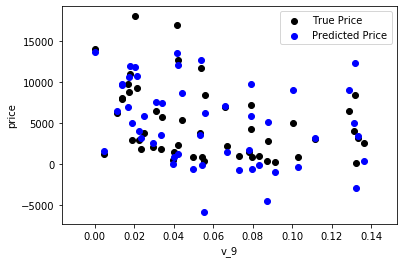

In [17]:
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50) #生成指定范围内的随机数
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

'''
绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大
且部分的预测值出现了小于0的情况，说明我们的模型存在一些问题
'''

It is clear to see the price shows a typical exponential distribution


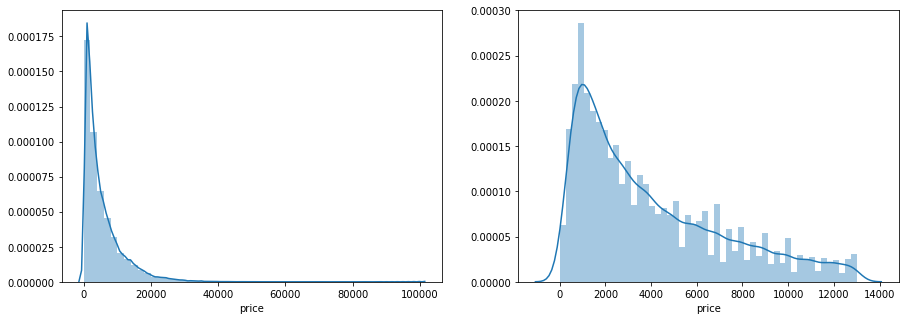

In [18]:
'''
通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差符合正态分布
而长尾分布的数据违背了这一假设
'''

import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [21]:
train_y_ln = np.log(train_y+1)  #对标签进行log(x+1)变换，使标签贴近于正态分布

The transformed price seems like normal distribution


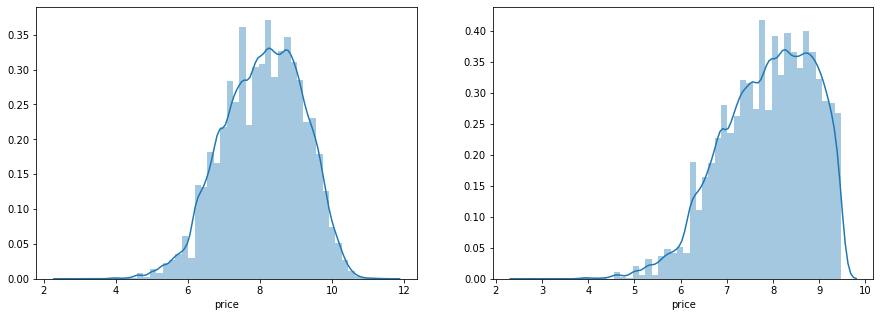

In [22]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [23]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:-76263007931.1788


[('offerType', 229469483424.36984),
 ('train', 76263007951.50758),
 ('seller', 50919250721.35306),
 ('brand_price_min_y', 7194142593.676309),
 ('brand_amount_y', 20016488.740268316),
 ('brand_price_average_x', 744515.1409582656),
 ('brand_price_median_x', 374715.3807615862),
 ('brand_price_std_x', 159260.2045211795),
 ('brand_price_max_y', 49195.01167053799),
 ('brand_price_sum_x', 20.54350214069605),
 ('v_9', 8.515250568972741),
 ('v_5', 7.6034198797196755),
 ('v_12', 1.9063377819176528),
 ('v_11', 1.6948584583444495),
 ('v_7', 1.0198847391149648),
 ('v_13', 0.9797493456836843),
 ('v_1', 0.8589029314199369),
 ('v_3', 0.8128755259705708),
 ('gearbox', 0.0103869120714974),
 ('fuelType', 0.00986615171241172),
 ('power_bin', 0.0059044078545009634),
 ('bodyType', 0.00532311992597986),
 ('power', 0.0010412391008115369),
 ('SaleID', 1.629141471452037e-08),
 ('name', -5.437034009419375e-08),
 ('used_time', -8.874753219923502e-06),
 ('city', -0.002791653463956211),
 ('v_14', -0.011101766474685

The predicted price seems normal after np.log transforming


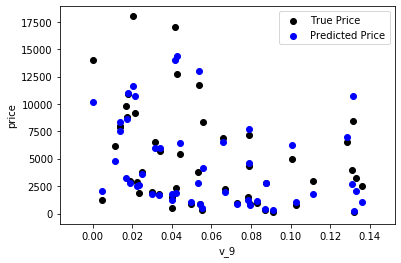

In [24]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [25]:
# 五折交叉验证
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [26]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [27]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [29]:
#使用线性回归模型，对未处理过标签的特征数据进行五折交叉验证
print('AVG:', np.mean(scores))

AVG: 2.1007223311274504e+303


In [30]:
#使用线性回归模型，对处理过标签的特征数据进行五折交叉验证
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [31]:
print('AVG:', np.mean(scores))

AVG: 0.19566446821606276


In [32]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.19256,0.196073,0.196645,0.194728,0.198316


In [33]:
# 模拟真实业务情况  用靠前时间的4/5当作训练集，靠后时间1/5当作验证集
import datetime

In [35]:
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

In [36]:
train = sample_feature.loc[:split_point].dropna() #删除带有空值的行，只要有一个空值，就删除整行
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [37]:
model = model.fit(train_X, train_y_ln)

In [38]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19832340867857876

In [54]:
#? learning_curve
#
from sklearn.model_selection import learning_curve
?learning_curve


In [51]:
# 绘制学习率曲线与验证曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'C:\\Users\\Richman\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

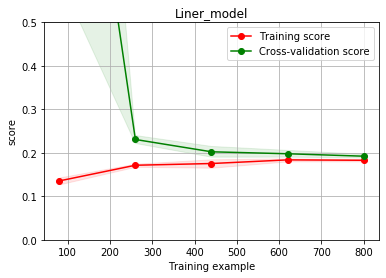

In [52]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [55]:
# 多种模型对比
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [56]:
# 线性模型&嵌入式特征选择
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [57]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [60]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [61]:
# 对三种方法的效果对比
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result


,LinearRegression,Ridge,Lasso
cv1,0.192463,0.196757,0.389907
cv2,0.195965,0.199923,0.385803
cv3,0.196462,0.200655,0.389073
cv4,0.194833,0.198855,0.385541
cv5,0.198281,0.202291,0.388556


intercept:19.97939680068277


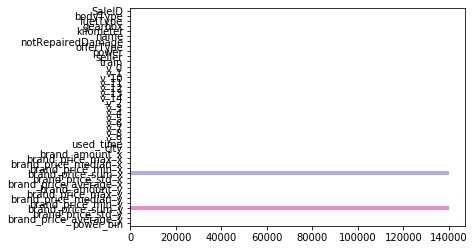

In [62]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:6.074946866639358


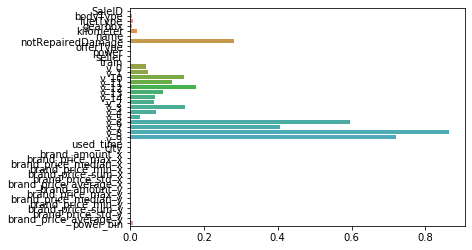

In [63]:
# L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型

model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.66362265557433


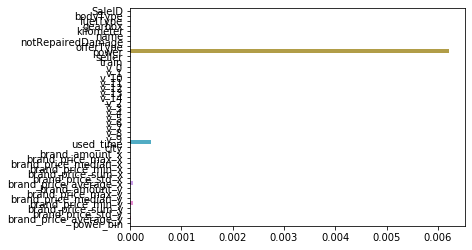

In [64]:
# L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power和used_time的特征非常重要
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [65]:
# 除了线性模型外，还有许多常用的非线性模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [66]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [67]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [68]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.192463,0.198131,0.145203,0.169269,2335.107076,0.142251,0.143690
cv2,0.195965,0.196381,0.145906,0.173228,1683.688570,0.143608,0.146775
cv3,0.196462,0.194979,0.146826,0.173740,770.475499,0.143394,0.146638
cv4,0.194833,0.195077,0.143825,0.171536,696.800508,0.140345,0.144429
cv5,0.198281,0.203725,0.152141,0.173578,1650.275273,0.154233,0.147320


In [69]:
# 模型调参
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []


In [70]:
# 贪心调参
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score


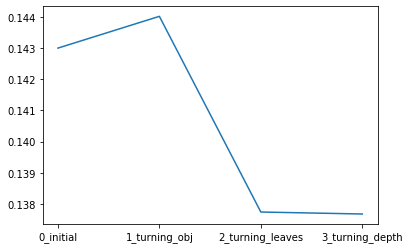

In [71]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [72]:
# Grid Search调参
from sklearn.model_selection import GridSearchCV

In [73]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [74]:
clf.best_params_

{'max_depth': 10, 'num_leaves': 55, 'objective': 'regression'}

In [75]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [76]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.14019787390273827

In [79]:
# 贝叶斯调参
from bayes_opt import BayesianOptimization


In [80]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [81]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [82]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8535   |  57.49    |  38.41    |  26.03    |  0.9066   |
|  2        |  0.8379   |  55.56    |  2.719    |  10.91    |  0.9073   |
|  3        |  0.8646   |  86.95    |  47.16    |  71.15    |  0.1917   |
|  4        |  0.8486   |  5.244    |  7.045    |  75.77    |  0.6559   |
|  5        |  0.864    |  23.44    |  38.01    |  65.77    |  0.8741   |
|  6        |  0.8051   |  2.85     |  99.88    |  97.53    |  0.687    |
|  7        |  0.8634   |  56.6     |  39.6     |  63.43    |  0.928    |
|  8        |  0.8652   |  71.31    |  35.8     |  76.41    |  0.697    |
|  9        |  0.8104   |  5.335    |  96.18    |  4.503    |  0.5937   |
|  10       |  0.8656   |  73.2     |  31.54    |  82.57    |  0.5416   |
|  11       |  0.8671   |  99.3     |  88.33    |  99.22    |  0.2076   |
|  12       |  0.8009   |  2.41     | 

In [83]:
1 - rf_bo.max['target']

0.13269909046910489